In [86]:
# import required libraries

import yfinance as yf
import matplotlib.pyplot as plt

In [87]:
# load the configuration form config.yaml

import yaml

with open("../config.yaml", "r") as file:
    config = yaml.safe_load(file)

ticker = config["params"]["ticker"]
start_date = config["params"]["start_date"]
end_date = config["params"]["end_date"]
short_window = config["params"]["short_window"]
long_window = config["params"]["long_window"]

In [88]:
# Fetch historical stock data
data = yf.download(ticker, start=start_date, end=end_date)
data.head(25)

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2020-01-02,72.796028,75.087502,75.150002,73.797501,74.059998,135480400
2020-01-03,72.088303,74.357498,75.144997,74.125000,74.287498,146322800
2020-01-06,72.662720,74.949997,74.989998,73.187500,73.447502,118387200
2020-01-07,72.320992,74.597504,75.224998,74.370003,74.959999,108872000
2020-01-08,73.484344,75.797501,76.110001,74.290001,74.290001,132079200
2020-01-09,75.045212,77.407501,77.607498,76.550003,76.809998,170108400
2020-01-10,75.214882,77.582497,78.167503,77.062500,77.650002,140644800
2020-01-13,76.821777,79.239998,79.267502,77.787498,77.910004,121532000


In [89]:
# Setting short and long term moving average

data["Short_MA"] = data["Close"].rolling(window=short_window).mean()
data["Long_MA"] = data["Close"].rolling(window=long_window).mean()

In [90]:
data["Short_MA"]

Date
2020-01-02           NaN
2020-01-03           NaN
2020-01-06           NaN
2020-01-07           NaN
2020-01-08           NaN
                 ...    
2022-12-23    136.839000
2022-12-27    135.392999
2022-12-28    133.449999
2022-12-29    132.089999
2022-12-30    131.432998
Name: Short_MA, Length: 756, dtype: float64

In [91]:
data["Long_MA"]

Date
2020-01-02           NaN
2020-01-03           NaN
2020-01-06           NaN
2020-01-07           NaN
2020-01-08           NaN
                 ...    
2022-12-23    136.839000
2022-12-27    135.392999
2022-12-28    133.449999
2022-12-29    132.089999
2022-12-30    131.432998
Name: Long_MA, Length: 756, dtype: float64

In [92]:
# Generate buy/sell signals

data['Signal'] = 0
data.loc[data['Short_MA'] > data['Long_MA'], 'Signal'] = 1  # Buy signal
data.loc[data['Short_MA'] <= data['Long_MA'], 'Signal'] = -1  # Sell signal

In [93]:
data

Price,Adj Close,Close,High,Low,Open,Volume,Short_MA,Long_MA,Signal
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,,
Date,,,,,,,,,
2020-01-02,72.796028,75.087502,75.150002,73.797501,74.059998,135480400,NaN,NaN,0
2020-01-03,72.088303,74.357498,75.144997,74.125000,74.287498,146322800,NaN,NaN,0
2020-01-06,72.662720,74.949997,74.989998,73.187500,73.447502,118387200,NaN,NaN,0
2020-01-07,72.320992,74.597504,75.224998,74.370003,74.959999,108872000,NaN,NaN,0
2020-01-08,73.484344,75.797501,76.110001,74.290001,74.290001,132079200,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...
2022-12-23,130.487823,131.860001,132.419998,129.639999,130.919998,63814900,136.839000,136.839000,-1
2022-12-27,128.676834,130.029999,131.410004,128.720001,131.380005,69007800,135.392999,135.392999,-1


In [94]:
# Backtest the strategy

data['Daily_Return'] = data['Close'].pct_change()
data['Strategy_Return'] = data['Signal'].shift(1) * data['Daily_Return']  # Lag signal by 1 day


In [95]:
data

Price,Adj Close,Close,High,Low,Open,Volume,Short_MA,Long_MA,Signal,Daily_Return,Strategy_Return
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,
Date,,,,,,,,,,,
2020-01-02,72.796028,75.087502,75.150002,73.797501,74.059998,135480400,NaN,NaN,0,NaN,NaN
2020-01-03,72.088303,74.357498,75.144997,74.125000,74.287498,146322800,NaN,NaN,0,-0.009722,-0.000000
2020-01-06,72.662720,74.949997,74.989998,73.187500,73.447502,118387200,NaN,NaN,0,0.007968,0.000000
2020-01-07,72.320992,74.597504,75.224998,74.370003,74.959999,108872000,NaN,NaN,0,-0.004703,-0.000000
2020-01-08,73.484344,75.797501,76.110001,74.290001,74.290001,132079200,NaN,NaN,0,0.016086,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,130.487823,131.860001,132.419998,129.639999,130.919998,63814900,136.839000,136.839000,-1,-0.002798,0.002798
2022-12-27,128.676834,130.029999,131.410004,128.720001,131.380005,69007800,135.392999,135.392999,-1,-0.013878,0.013878


In [96]:
# Cumulative returns

data['Cumulative_Market_Return'] = (1 + data['Daily_Return']).cumprod()
data['Cumulative_Strategy_Return'] = (1 + data['Strategy_Return']).cumprod()

In [97]:
data

Price,Adj Close,Close,High,Low,Open,Volume,Short_MA,Long_MA,Signal,Daily_Return,Strategy_Return,Cumulative_Market_Return,Cumulative_Strategy_Return
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,,
Date,,,,,,,,,,,,,
2020-01-02,72.796028,75.087502,75.150002,73.797501,74.059998,135480400,NaN,NaN,0,NaN,NaN,NaN,NaN
2020-01-03,72.088303,74.357498,75.144997,74.125000,74.287498,146322800,NaN,NaN,0,-0.009722,-0.000000,0.990278,1.000000
2020-01-06,72.662720,74.949997,74.989998,73.187500,73.447502,118387200,NaN,NaN,0,0.007968,0.000000,0.998169,1.000000
2020-01-07,72.320992,74.597504,75.224998,74.370003,74.959999,108872000,NaN,NaN,0,-0.004703,-0.000000,0.993474,1.000000
2020-01-08,73.484344,75.797501,76.110001,74.290001,74.290001,132079200,NaN,NaN,0,0.016086,0.000000,1.009456,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,130.487823,131.860001,132.419998,129.639999,130.919998,63814900,136.839000,136.839000,-1,-0.002798,0.002798,1.756085,0.393209
2022-12-27,128.676834,130.029999,131.410004,128.720001,131.380005,69007800,135.392999,135.392999,-1,-0.013878,0.013878,1.731713,0.398666


In [98]:
# Plot the results

plt.figure(figsize=(16, 8))

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

/var/folders/bl/c9xq73wj61b5k_gjtrh9b0zh0000gn/T/ipykernel_1773/1002890467.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.xticks(pd.date_range(start=start_date, end=end_date, freq="6M"), rotation=45, fontsize=10)


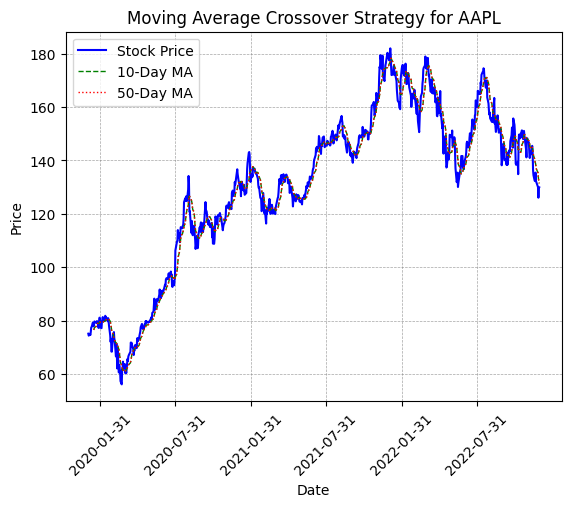

In [99]:
# Plot stock price and moving averages

plt.plot(data['Close'], label="Stock Price", color="blue", linewidth=1.5)
plt.plot(data['Short_MA'], label="10-Day MA", color="green", linestyle="--", linewidth=1)
plt.plot(data['Long_MA'], label="50-Day MA", color="red", linestyle=":", linewidth=1)

import pandas as pd

# Improve x-axis readability
plt.xticks(pd.date_range(start=start_date, end=end_date, freq="6M"), rotation=45, fontsize=10)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Moving Average Crossover Strategy for AAPL")
plt.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)

# Legend inside the plot
plt.legend(loc="upper left", fontsize=10)
plt.legend()

/var/folders/bl/c9xq73wj61b5k_gjtrh9b0zh0000gn/T/ipykernel_1773/1965445381.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.xticks(pd.date_range(start=start_date, end=end_date, freq="6M"), rotation=45, fontsize=10)


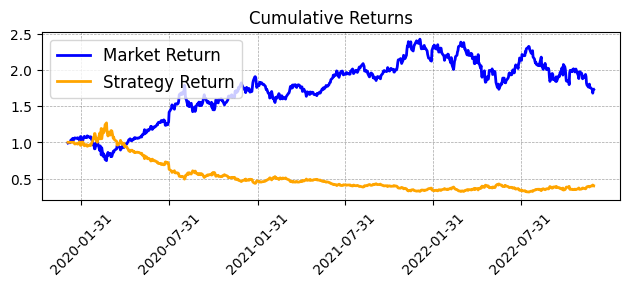

In [100]:
# Plot cumulative returns

plt.subplot(2, 1, 2)
plt.plot(data['Cumulative_Market_Return'], label="Market Return", color="blue", linewidth=2)
plt.plot(data['Cumulative_Strategy_Return'], label="Strategy Return", color="orange", linewidth=2)
plt.title("Cumulative Returns")

# Improve x-axis readability with rotation and limited ticks
plt.xticks(pd.date_range(start=start_date, end=end_date, freq="6M"), rotation=45, fontsize=10)

# Add gridlines for better visualization
plt.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)

# Adjust legend position and format
plt.legend(loc="upper left", fontsize=12)

# Save the figure (optional) and show plot
plt.tight_layout()

plt.tight_layout()
plt.show()

In [101]:
# Strategy performance metrics
sharpe_ratio = (data['Strategy_Return'].mean() / data['Strategy_Return'].std()) * (252**0.5)
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Sharpe Ratio: -0.65
